## Radiology 229 - Class 15 Exercises (Lectures 11A,B)

[Class Website](https://web.stanford.edu/class/rad229)

This class notebook is built (in part) from the Matlab folder, Lecture11.mlx. 

Objectives:
1) Radial and Spiral Design
2) Gridding Reconstruction

First we import basic libraries including  <code>mrsigpy</code>.


In [1]:
# -- We use the functions in mrsigpy, as well as standard numpy and matpltlib
import numpy as np
import mrsigpy as mrs
import matplotlib.pyplot as plt
#from PIL import Image


# Basic Spiral Design

Spiral design uses VDS (Variable Density Spiral).  At this time the units are CGS, so the parameters to vds are:

* Max slew rate (G/cm/s)
* Maximum gradient amplitude (G/cm)
* Sampling period (s) for gradient AND acquisition.
* number of interleaves.
* Fcoeff = FOV coefficients with respect to r - see above.
* rmax= value of k-space radius at which to stop (cm^-1).
 		(rmax = 1/(2*resolution)) 

The default in mrsigpy is <code>vds(15000,5,0.000004,20,20,5)</code> to achieve 1mm resolution over 20cm FOV.  

vds: smax,gmax,T,N,Fcoeff,rmax 15000 5 4e-06 20 [20  0  0] 5.0
1000 points, |k|= 0.8413756957228362
2000 points, |k|= 1.4300677968925126
3000 points, |k|= 1.918366638924729
4000 points, |k|= 2.351811297230694
5000 points, |k|= 2.7407245907656548
6000 points, |k|= 3.0819076480980883
7000 points, |k|= 3.388994139084223
8000 points, |k|= 3.670528149559699
9000 points, |k|= 3.9319892933870153
10000 points, |k|= 4.1771407971367704
11000 points, |k|= 4.408699292872563
12000 points, |k|= 4.628701924243972
13000 points, |k|= 4.838722836217296


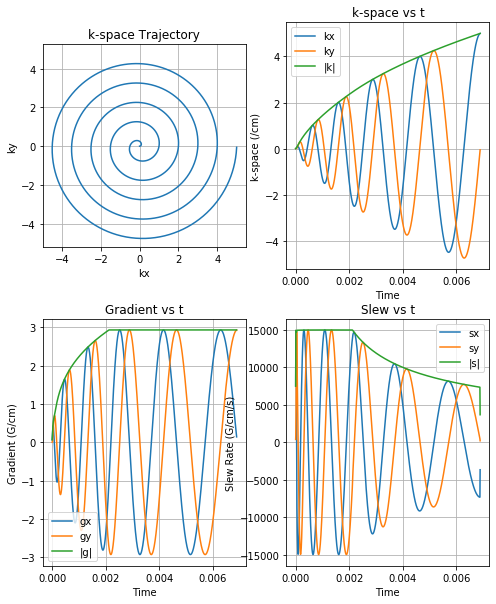

In [2]:


# -- Use defaults:
#k,g,s,t = mrs.vds()

# -- Verbose (or vary parameters)
N = 20  # interleaves
res=0.1 # cm
T = 0.000004 # sec
FOV = 20 # cm
vdFOV = np.array((FOV,0,0))  # (FOV = sum_n { F_n(kr/krmax)**n} )

k,g,s,t = mrs.vds(15000,5,T,N,vdFOV,0.5/res)




mrs.plotktraj(k,g,s,t)


# Spiral Design Exercises

Trajectory Design:
1.  What happens to the trajectory length when the number of interleaves (N) increases?
1.  As (N) increases, is the slew-rate-limited fraction greater or smaller?
1.  If you divde N and FOV by the same number, does the trajectory change?

Trajectory Length:
1.  Can you estimate the length of a spiral trajectory, give N interleaves and a FOV?  
1.  Explain why this estimate is better for lower N.

Variable-Density Spiral:
1.  Try variable-density (FOV = [20 -5]) and explain what you see
1.  Is the variable-density trajectory for a given resolution longer or shorter?
1.  Is the variable-density trajectory more or less slew-rate limited than constant density?



In [3]:
# Estmate length of trajectory
deltak = 1/FOV                      # K-space spacing for FOV
kmax = 0.5/res                      # Max k radius for resolution

# Assume the trajectories, and samples along trajectories are both 1/FOV apart
karea = 3.14*kmax**2                # Circle area
est_num_pts = karea/deltak/deltak   # k-area divided by spacing "box"
print("Estimated Trajectory Length (s)",est_num_pts/N*T)


Estimated Trajectory Length (s) 0.00628


# Density Compensation

For Non-Cartesion reconstruction, we will need to compensate for varying density.  Look at the density compensation (1/density) for the most recently-generated spiral trajectory.  Note what happens when you use a variable denisty spiral.  

Shape of dcf (1724,)


/Users/brian/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


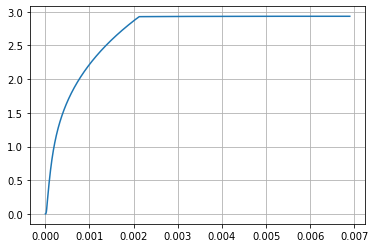

In [4]:
dcf,k = mrs.vecdcf(g)
print("Shape of dcf",dcf.shape)

plt.figure()
plt.plot(t,dcf)
plt.grid()
plt.show()



# Interleaving Trajectories

For spirals (and other radial trajectories) once the k-space and gradients of one trajectory are designed, the next step is to rotate the trajectory to create the other interleaves.  This is also a good time to calculate density compensation for the whole trajectory.  Often this is stored in an M x N array, where M is the number of points along an interleaf, and N is the number of interleaves.

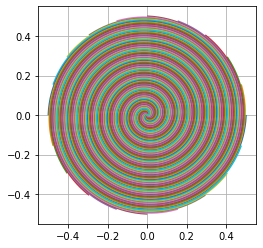

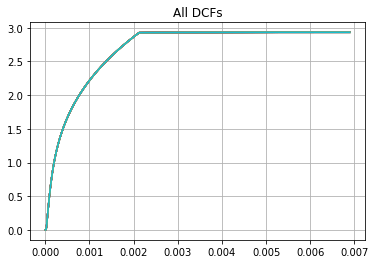

In [5]:
# Interleave the trajctory
ksp,dcf = mrs.rotate_spirals(g,k,N) 

plt.figure()
plt.plot(np.real(ksp),np.imag(ksp))
plt.axis('square')
plt.grid()
plt.show()

plt.figure()
plt.plot(t,dcf)
plt.grid()
plt.title("All DCFs")
plt.show()


# Gridding and Images

Now we will use this trajectory... fortunately we can directly synthesize k-space data, so we can see how it reconstructs.

Gridded point


0.00+0.00j 0.00+0.00j 0.00+0.00j 0.00+0.00j
0.00+0.00j 0.00+0.00j 0.00+0.00j 0.00+0.00j
0.00+0.00j 0.00+0.00j 0.00+0.00j 0.00+0.00j
0.00+0.00j 0.00+0.00j 0.00+0.00j 0.00+0.00j
kdata size (1724, 20)
kdat size is  (1724, 20)
dat size is  (256, 256)


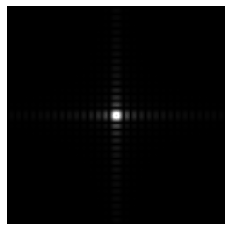

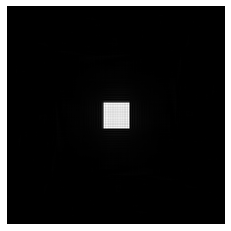

In [9]:
# Sample test - put a 1 somewhere and grid!
kloc = np.array([[0]])
kdat = np.array([[1]])
d = kdat.copy()
dat = mrs.gridmat(kloc,kdat,dcf,gridsize=4)
print("Gridded point")
mrs.show_matrix(dat)



# Actual Data and square...
scenter = np.array([0])
kdat = mrs.ksquare(center=scenter, swidth=30, kloc=ksp, tsamp=0.000004, df=0)
print("kdat size is ",kdat.shape)
dat = mrs.gridmat(ksp, kdat, dcf, gridsize=256)
print("dat size is ",dat.shape)

mrs.dispim(dat)
im = mrs.ft(dat)
mrs.dispim(im)


# Grid size and k-space size

We can "overgrid" which means our grid is much finer than we need.  This will reconstruct the aliased ring from _sampling_

We can also scale our k-space _down_ so that we effectively zero-pad k-space.  This will interpoloate to show the PSF of the sampling pattern.

dat size is  (512, 512)


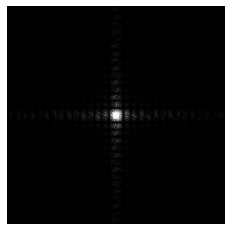

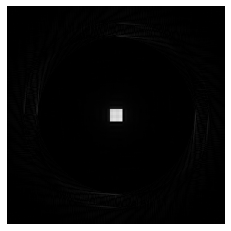

dat size is  (512, 512)


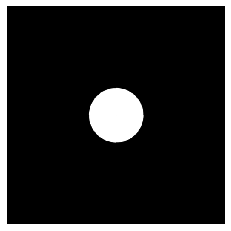

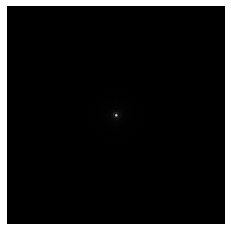

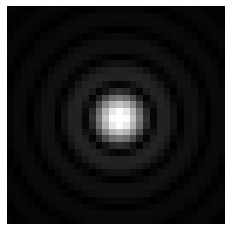

In [ ]:
dat = mrs.gridmat(ksp, kdat, dcf, gridsize=512)
print("dat size is ",dat.shape)
mrs.dispim(dat)  # looks the same
im = mrs.ft(dat)
mrs.dispim(im)   # zooms out

kones = np.ones_like(kdat)
dat = mrs.gridmat(ksp/4, kones, dcf, gridsize=512)
print("dat size is ",dat.shape)
mrs.dispim(dat)     # Gridded 1's 
im = mrs.ft(dat)
imc = mrs.zpadcrop(im,(32,32))      # Crop to show PSF
mrs.dispim(imc)                     # Show PSF

